In [1]:
import torch

import os
# os.environ['TRITON_INTERPRET'] = '1'
import triton
import triton.language as tl
# import math

DEVICE = triton.runtime.driver.active.get_active_torch_device()

In [2]:
def _get_cuda_autotune_config():
    configs = []
    for num_warps, num_stages in [
        (4, 2),
        (4, 3),
        (4, 4),
        (8, 2),
        (8, 4),
    ]:
        for GROUP_SIZE_M in [8, 32, 64]:
            for BLOCK_SIZE_M in [16]:
                for BLOCK_SIZE_N in [32, 64, 128]:#[64, 128]:
                    for BLOCK_SIZE_K in [32, 64, 128]:#[16, 32]:
                        configs.append(
                            triton.Config(
                                {
                                    "GROUP_SIZE_M" : GROUP_SIZE_M,
                                    "BLOCK_SIZE_M" : BLOCK_SIZE_M,
                                    "BLOCK_SIZE_N" : BLOCK_SIZE_N,
                                    "BLOCK_SIZE_K" : BLOCK_SIZE_K,
                                }, 
                                num_stages=num_stages, 
                                num_warps=num_warps
                            ),
                        )                        
    return configs
    return [triton.Config(
                                {
                                    "GROUP_SIZE_M" : 1,
                                    "BLOCK_SIZE_M" : 16,
                                    "BLOCK_SIZE_N" : 32,
                                    "BLOCK_SIZE_K" : 32,
                                },
                                num_stages=3, 
                                num_warps=4
                            )]

In [3]:
@triton.autotune(
    configs=_get_cuda_autotune_config(),
    key=['M', 'N', 'K'],
)
@triton.jit
def matmul_kernel_w4a16(
        # Pointers to matrices
        a_ptr, b_ptr, c_ptr,
        # Matrix dimensions
        M, N, K,
        stride_am, stride_ak,  #
        stride_bk, stride_bn,  #
        stride_cm, stride_cn,
        # Meta-parameters
        BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,  #
        GROUP_SIZE_M: tl.constexpr,  #
):
    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + ((pid % num_pid_in_group) % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    tl.assume(pid_m >= 0)
    tl.assume(pid_n >= 0)
    tl.assume(stride_am > 0)
    tl.assume(stride_ak > 0)
    tl.assume(stride_bn > 0)
    tl.assume(stride_bk > 0)
    tl.assume(stride_cm > 0)
    tl.assume(stride_cn > 0)
    # tl.multiple_of(stride_am, BLOCK_SIZE_M)
    # tl.multiple_of(stride_bn, BLOCK_SIZE_N)
    # tl.multiple_of(a_ptrs.shape, 16)
    # tl.multiple_of(b_ptrs.shape, 16)

    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    
    offs_bn = (pid_n * (BLOCK_SIZE_N // 8) + tl.arange(0, BLOCK_SIZE_N // 8)) % (N // 8)
    b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)

    # For bits unpack
    shifter = tl.arange(0, 8) * 4
    
    accumulator_dtype = tl.float32 #tl.float16
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=accumulator_dtype)
    

    a = tl.load(a_ptrs, mask=offs_k[None, :] < K, other=0.0)
    b_bits = tl.load(b_ptrs, eviction_policy="evict_first")
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        a_next = tl.load(a_ptrs + BLOCK_SIZE_K * stride_ak, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)
        b_bits_next = tl.load(b_ptrs + BLOCK_SIZE_K * stride_bk)

        b = (b_bits[:, :, None] >> shifter[None, None, :]) & 0xF
        b = tl.reshape(b, BLOCK_SIZE_K, BLOCK_SIZE_N)
        b = b.to(tl.float16)

        accumulator = tl.dot(a, b, accumulator, out_dtype=accumulator_dtype)        
        a, b_bits = a_next, b_bits_next

    c = accumulator.to(tl.float16)

    # -----------------------------------------------------------
    # Write back the block of the output matrix C with masks.
    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, c, mask=c_mask)


def triton_matmul_w4a16(a, b):
    # Check constraints.
    assert a.shape[1] == b.shape[0], "Incompatible dimensions"
    assert a.is_contiguous(), "Matrix A must be contiguous"

    assert a.dtype == torch.float16
    assert b.dtype == torch.int32
    
    M, K = a.shape
    N = b.shape[1] * 8
    # Allocates output.
    c = torch.empty((M, N), device=a.device, dtype=torch.float16)
    # 1D launch kernel where each block gets its own program.
    grid = lambda META: (triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']), )
    matmul_kernel_w4a16[grid](
        a, b, c,  #
        M, N, K,  #
        a.stride(0), a.stride(1),  #
        b.stride(0), b.stride(1),  #
        c.stride(0), c.stride(1),  #
    )
    return c


In [ ]:
@triton.autotune(
    configs=_get_cuda_autotune_config(),
    key=['M', 'N', 'K'],
)
@triton.jit
def matmul_kernel_w4a16_opt(
        # Pointers to matrices
        a_ptr, b_ptr, c_ptr,
        # Matrix dimensions
        M, N, K,
        stride_am, stride_ak,  #
        stride_bk, stride_bn,  #
        stride_cm, stride_cn,
        # Meta-parameters
        BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,  #
        GROUP_SIZE_M: tl.constexpr,  #
):
    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + ((pid % num_pid_in_group) % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m


    tl.assume(pid_m >= 0)
    tl.assume(pid_n >= 0)
    tl.assume(stride_am > 0)
    tl.assume(stride_ak > 0)
    tl.assume(stride_bn > 0)
    tl.assume(stride_bk > 0)
    tl.assume(stride_cm > 0)
    tl.assume(stride_cn > 0)


    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    
    offs_bn = (pid_n * (BLOCK_SIZE_N // 8) + tl.arange(0, BLOCK_SIZE_N // 8)) % (N // 8)
    b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)

    # For bits unpack
    shifter = tl.arange(0, 8) * 4
    
    accumulator_dtype = tl.float32 #tl.float16
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=accumulator_dtype)
    

    a = tl.load(a_ptrs, mask=offs_k[None, :] < K, other=0.0)
    b_bits = tl.load(b_ptrs, eviction_policy="evict_first")
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        a_next = tl.load(a_ptrs + BLOCK_SIZE_K * stride_ak, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)
        b_bits_next = tl.load(b_ptrs + BLOCK_SIZE_K * stride_bk)

        b = (b_bits[:, :, None] >> shifter[None, None, :]) & 0xF
        b = tl.reshape(b, BLOCK_SIZE_K, BLOCK_SIZE_N)
        b = b.to(tl.float16)

        accumulator = tl.dot(a, b, accumulator, out_dtype=accumulator_dtype)        
        a, b_bits = a_next, b_bits_next

    c = accumulator.to(tl.float16)

    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, c, mask=c_mask)


def triton_matmul_w4a16_opt(a, b):
    # Check constraints.
    assert a.shape[1] == b.shape[0], "Incompatible dimensions"
    assert a.is_contiguous(), "Matrix A must be contiguous"

    assert a.dtype == torch.float16
    assert b.dtype == torch.int32
    
    M, K = a.shape
    N = b.shape[1] * 8
    # Allocates output.
    c = torch.empty((M, N), device=a.device, dtype=torch.float16)
    # 1D launch kernel where each block gets its own program.
    grid = lambda META: (triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']), )
    matmul_kernel_w4a16_opt[grid](
        a, b, c,  #
        M, N, K,  #
        a.stride(0), a.stride(1),  #
        b.stride(0), b.stride(1),  #
        c.stride(0), c.stride(1),  #
    )
    return c


In [10]:
def decode_int32_to_int4(bits):
    v0 = bits & 0xF
    v1 = (bits >> 4) & 0xF
    v2 = (bits >> 8) & 0xF
    v3 = (bits >> 12) & 0xF
    v4 = (bits >> 16) & 0xF
    v5 = (bits >> 20) & 0xF
    v6 = (bits >> 24) & 0xF
    v7 = (bits >> 28) & 0xF
    
    w = torch.stack([v0, v1, v2, v3, v4, v5, v6, v7], dim=-1) - 0x8
    return w.reshape(bits.shape[0], bits.shape[1] * 8)


torch.manual_seed(0)

M, K, N = (1, 4096, 4096)

y = torch.randn(M, K, dtype=torch.float16, device="cuda") / (M * K)

# x_compressed = torch.randint(-2**31, 2**31, (K, N // 8), dtype=torch.int32, device="cuda")
# x_decompressed = decode_int32_to_int4(x_compressed)
# o1 = torch.matmul(y, x_decompressed.to(torch.float16))
# o2 = triton_matmul_w4a16(y, x_compressed)


x_compressed = torch.randint(-2**31, 2**31, (K, N // 8), dtype=torch.int32, device="cuda")
x_decompressed = decode_int32_to_int4(x_compressed)
o1 = torch.matmul(y, x_decompressed.to(torch.float16))

o3 = triton_matmul_w4a16_opt(y, x_compressed)

# print(matmul_kernel_.best_config)
# assert torch.all(torch.isclose(o1, o2))


In [ ]:
x_compressed.shape
# 256, 8192

torch.Size([4096, 512])

In [6]:
import torch.nn as nn
import marlin
DEV = torch.device('cuda:0')


def gen_quant4(m, n, groupsize=-1):
    maxq = 2 ** 4 - 1
    w = torch.randn((m, n), dtype=torch.half, device=DEV)
    if groupsize != -1:
        w = w.reshape((-1, groupsize, n))
        w = w.permute(1, 0, 2)
        w = w.reshape((groupsize, -1))
    s = torch.max(torch.abs(w), 0, keepdim=True)[0]
    s *= 2 / maxq
    w = torch.round(w / s).int()
    w += (maxq + 1) // 2
    w = torch.clamp(w, 0, maxq)
    ref = (w - (maxq + 1) // 2).half() * s
    if groupsize != -1:
        def reshape(w):
            w = w.reshape((groupsize, -1, n))
            w = w.permute(1, 0, 2)
            w = w.reshape((m, n)).contiguous()
            return w
        ref = reshape(ref)
        w = reshape(w)
    s = s.reshape((-1, n)).contiguous()
    linear = nn.Linear(m, n)
    linear.weight.data = ref.t()
    # Workaround to test some special cases that are forbidden by the API
    layer = marlin.Layer(256, 256, groupsize=groupsize)
    if groupsize == -1:
        groupsize = m
    layer.k = m
    layer.n = n
    layer.groupsize = groupsize
    layer.B = torch.empty((m // 16, n * 16 // 8), dtype=torch.int, device=DEV)
    layer.s = torch.empty((m // groupsize, n), dtype=torch.half, device=DEV)
    layer.pack(linear, s.t())
    q = layer.B
    s = layer.s
    return ref, q, s


def marline_matmul(A, B, scales):
    M, K = A.shape
    N = B.shape[-1] // 2

    C = torch.zeros((M, N), dtype=torch.half, device=DEV)
    workspace = torch.zeros(N // 128 * 16, device=DEV)

    thread_k, thread_n = 128, 128
    marlin.mul(A, B, C, scales, workspace, thread_k, thread_n, -1)
    return C


16 4096 1024
GROUP_SIZE_M: 32, BLOCK_SIZE_M: 16, BLOCK_SIZE_N: 32, BLOCK_SIZE_K: 32, num_warps: 8, num_ctas: 1, num_stages: 2, maxnreg: None

16 8192 2048
GROUP_SIZE_M: 8, BLOCK_SIZE_M: 16, BLOCK_SIZE_N: 32, BLOCK_SIZE_K: 64, num_warps: 4, num_ctas: 1, num_stages: 2, maxnreg: None

16 16384 4096
GROUP_SIZE_M: 64, BLOCK_SIZE_M: 16, BLOCK_SIZE_N: 32, BLOCK_SIZE_K: 32, num_warps: 8, num_ctas: 1, num_stages: 2, maxnreg: None

16 32768 8192
GROUP_SIZE_M: 64, BLOCK_SIZE_M: 16, BLOCK_SIZE_N: 64, BLOCK_SIZE_K: 64, num_warps: 4, num_ctas: 1, num_stages: 2, maxnreg: None
matmul-performance:
         K     M       N  torch_fp16  triton_w4a16_opt
0   4096.0  16.0  1024.0    2.570039          4.096000
1   8192.0  16.0  2048.0    3.942015          5.890876
2  16384.0  16.0  4096.0    5.114030          7.855881
3  32768.0  16.0  8192.0    5.165896          8.765525


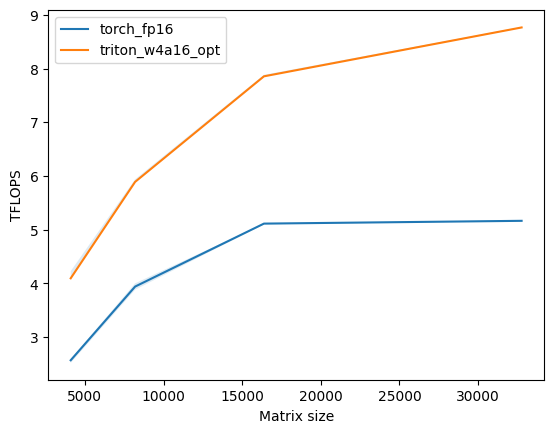

In [ ]:
BS = 16
# sizes = [1024, 2048, 4096, 8192, 16384]
sizes = [1024, 2048, 4096, 8192]
configs = []
configs.append(
    triton.testing.Benchmark(
        x_names=["K", "M", "N"],  # Argument names to use as an x-axis for the plot
        # x_vals=[(BS * size, size, size) for size in sizes],
        x_vals=[(size, BS, size) for size in sizes],
        line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        # Don't compare to cublas for fp8 cases as torch.matmul doesn't support fp8 at the moment.
        line_vals=[
            "torch_fp16",
            # "triton_w4a16",
            "triton_w4a16_opt",
            # "marline_w4a16",
            ],
        line_names=[
            "torch_fp16",
            # "triton_w4a16",
            "triton_w4a16_opt",
            # "marline_w4a16",
            ],
        ylabel="TFLOPS",  # Label name for the y-axis
        xlabel="Matrix size",
        plot_name="matmul-performance",  # Name for the plot, used also as a file name for saving the plot.
        args={},
    ))


@triton.testing.perf_report(configs)
def benchmark(M, K, N, provider):
    y_fp16 = torch.randn(M, K, dtype=torch.float16, device="cuda").contiguous() / (M * K)
    
    # x_compressed = torch.randint(-2**31, 2**31, (K, N // 8), dtype=torch.int32, device="cuda").contiguous()
    x_compressed = torch.randint(-2**31, 2**31, (N // 8, K), dtype=torch.int32, device="cuda").T
    
    x_decompressed = decode_int32_to_int4(x_compressed).to(torch.float16).contiguous()
    _, x_compressed_marline, scales_marline = gen_quant4(K, N, groupsize=128)
    # print(x_decompressed.shape, x_compressed.shape, x_compressed_marline.shape)

    quantiles = [0.5, 0.2, 0.8]
    if provider == "torch_fp16":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(y_fp16, x_decompressed), quantiles=quantiles)
    if provider == "triton_w4a16":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: triton_matmul_w4a16(y_fp16, x_compressed), quantiles=quantiles)
    if provider == "triton_w4a16_opt":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: triton_matmul_w4a16_opt(y_fp16, x_compressed), quantiles=quantiles)
        print()
        print(M, K, N)
        print(matmul_kernel_w4a16_opt.best_config)
    if provider == "marline_w4a16":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: marline_matmul(y_fp16, x_compressed_marline, scales_marline), quantiles=quantiles)

    perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)

benchmark.run(show_plots=False, print_data=True)